# Utilizando dataset direto do servidor

In [132]:
import pandas as pd
import matplotlib.pyplot as plt

In [133]:
try:
    df_servidor_plx2 = pd.read_csv('dados_estrelas.csv')
except Exception:
    print("Erro ao ler arquivo. Reexecutando query...")
    from astroquery.gaia import Gaia

    query = """
    SELECT TOP 300000
        gs.source_id,
        gs.parallax,
        gs.phot_g_mean_mag,
        gs.bp_rp,
        ap.teff_gspphot,
        gs.phot_g_mean_mag + 5*LOG10(gs.parallax/1000) + 5 AS abs_mag
    FROM gaiadr3.gaia_source AS gs
    JOIN gaiadr3.astrophysical_parameters AS ap
    USING (source_id)
    WHERE gs.parallax > 2
    AND ap.teff_gspphot IS NOT NULL
    """
    job = Gaia.launch_job_async(query)
    df_servidor_plx2 = job.get_results().to_pandas()
    df_servidor_plx2.to_csv('dados_estrelas.csv')

In [134]:
df_servidor_plx2.describe()

,Unnamed: 0.1,Unnamed: 0,source_id,parallax,phot_g_mean_mag,bp_rp,teff_gspphot,abs_mag
count,300000.000000,300000.000000,3.000000e+05,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,149999.500000,149999.500000,3.700099e+17,3.405916,16.125536,2.127780,4103.781641,8.583175
std,86602.684716,86602.684716,4.102788e+17,2.263256,2.397297,0.722697,963.533742,2.373888
min,0.000000,0.000000,3.436113e+10,2.000008,2.904279,-0.343252,2584.621300,-3.461425
25%,74999.750000,74999.750000,8.745449e+16,2.304526,14.556023,1.515538,3404.531000,6.903339
50%,149999.500000,149999.500000,1.909898e+17,2.778709,16.830383,2.340469,3648.954850,9.301763
75%,224999.250000,224999.250000,4.991040e+17,3.750066,18.087014,2.693629,4619.976000,10.409133
max,299999.000000,299999.000000,1.574502e+18,392.752945,18.999958,4.717266,38816.120000,14.644616


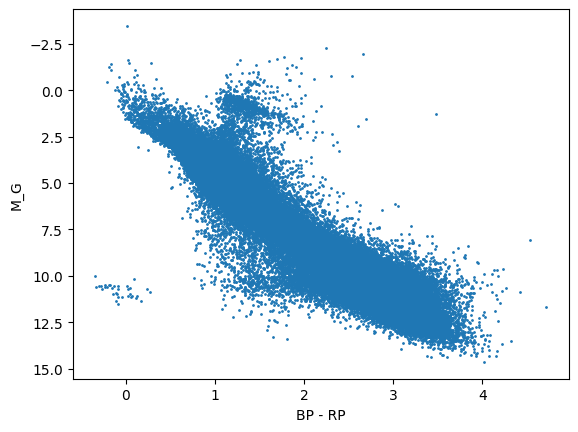

In [135]:
plt.figure()
plt.scatter(df_servidor_plx2["bp_rp"], df_servidor_plx2["abs_mag"], s=1)
plt.gca().invert_yaxis()
plt.xlabel("BP - RP")
plt.ylabel("M_G")
plt.show()

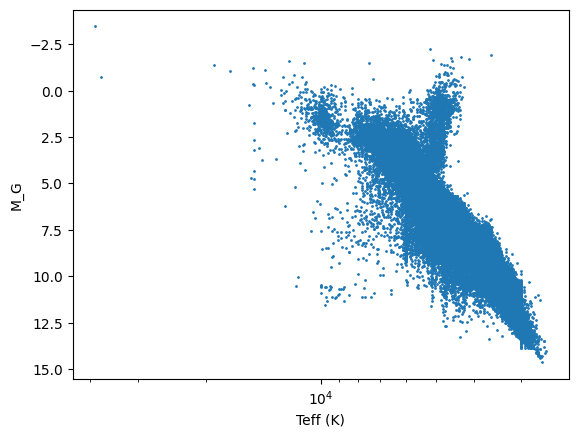

In [136]:
plt.figure()
plt.scatter(df_servidor_plx2["teff_gspphot"], df_servidor_plx2["abs_mag"], s=1)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()  # temperatura decresce para a direita
plt.xscale('log')
plt.xlabel("Teff (K)")
plt.ylabel("M_G")
plt.show()

# Funções úteis

In [137]:
# Diagramas
def diagrama_HR(dados, eixos, titulos, log_x=False, log_y=False, inv_x=False, inv_y=False):
    plt.figure()
    plt.scatter(dados[eixos[0]], dados[eixos[1]], s=1)

    if inv_x:
        plt.gca().invert_xaxis()
    if inv_y:
        plt.gca().invert_yaxis()
    if log_x:
        plt.xscale("log")
    if log_y:
        plt.yscale("log")

    plt.xlabel(titulos[0])
    plt.ylabel(titulos[1])
    plt.show()

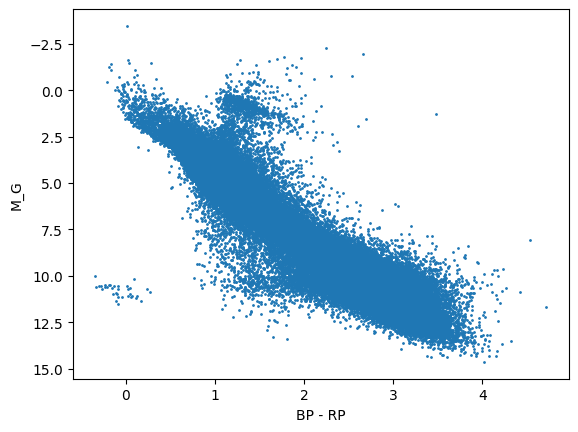

In [138]:
diagrama_HR(df_servidor_plx2, ["bp_rp", "abs_mag"], ["BP - RP", "M_G"], inv_y=True)

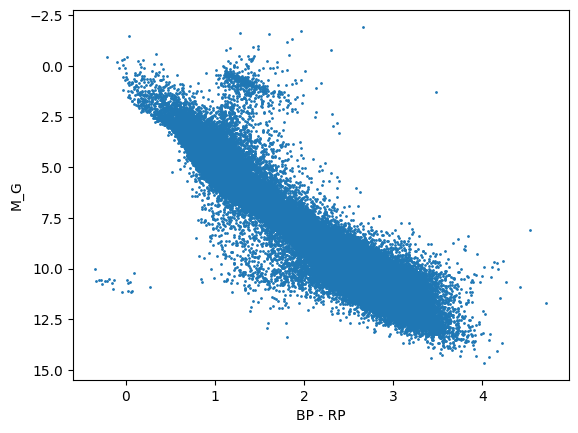

In [202]:
try:
    df_novo = pd.read_csv('dados_estrelas_sample.csv')
except:
    df_novo = df_servidor_plx2.sample(150000)
    df_novo.to_csv('dados_estrelas_sample2.csv')
diagrama_HR(df_novo, ["bp_rp", "abs_mag"], ["BP - RP", "M_G"], inv_y=True)

# Teste novo de dataset

# Testes - Clustering

In [203]:
# Obtenção, Tratamento e Processamento dos Dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt

# Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
import scipy.cluster.hierarchy as sch
import hdbscan

In [204]:
dados = pd.read_csv("dados_estrelas_sample2.csv")

dados["log_teff"] = np.log10(dados["teff_gspphot"])
dados = dados[["bp_rp", "abs_mag", "log_teff"]]

scaler = StandardScaler()
dados[["bp_rp_s", "abs_mag_s", "log_teff_s"]] = scaler.fit_transform(dados[["bp_rp", "abs_mag", "log_teff"]])

## HDBSCAN

In [205]:
cluster_hdbscan = hdbscan.HDBSCAN(min_cluster_size=12, gen_min_span_tree=True)
cluster_hdbscan.fit(dados[["bp_rp_s", "abs_mag_s", "log_teff_s"]])

,min_cluster_size,12
,min_samples,None
,cluster_selection_epsilon,0.0
,cluster_selection_persistence,0.0
,max_cluster_size,0
,metric,'euclidean'
,alpha,1.0
,p,None
,algorithm,'best'
,leaf_size,40
,memory,Memory(location=None)


In [206]:
dados["hdbscan"] = cluster_hdbscan.labels_

dados.head()

,bp_rp,abs_mag,log_teff,bp_rp_s,abs_mag_s,log_teff_s,hdbscan
0,1.772161,7.435327,3.657464,-0.496151,-0.488183,0.602637,5
1,2.524457,9.139374,3.580962,0.546516,0.231790,-0.236604,5
2,2.505983,10.437107,3.511573,0.520912,0.780092,-0.997819,5
3,1.952094,7.527750,3.652797,-0.246768,-0.449134,0.551438,5
4,1.090321,5.475107,3.760245,-1.441169,-1.316392,1.730171,5


In [207]:
dados["hdbscan"].unique()

array([ 5, -1,  4,  1,  3,  2,  0])

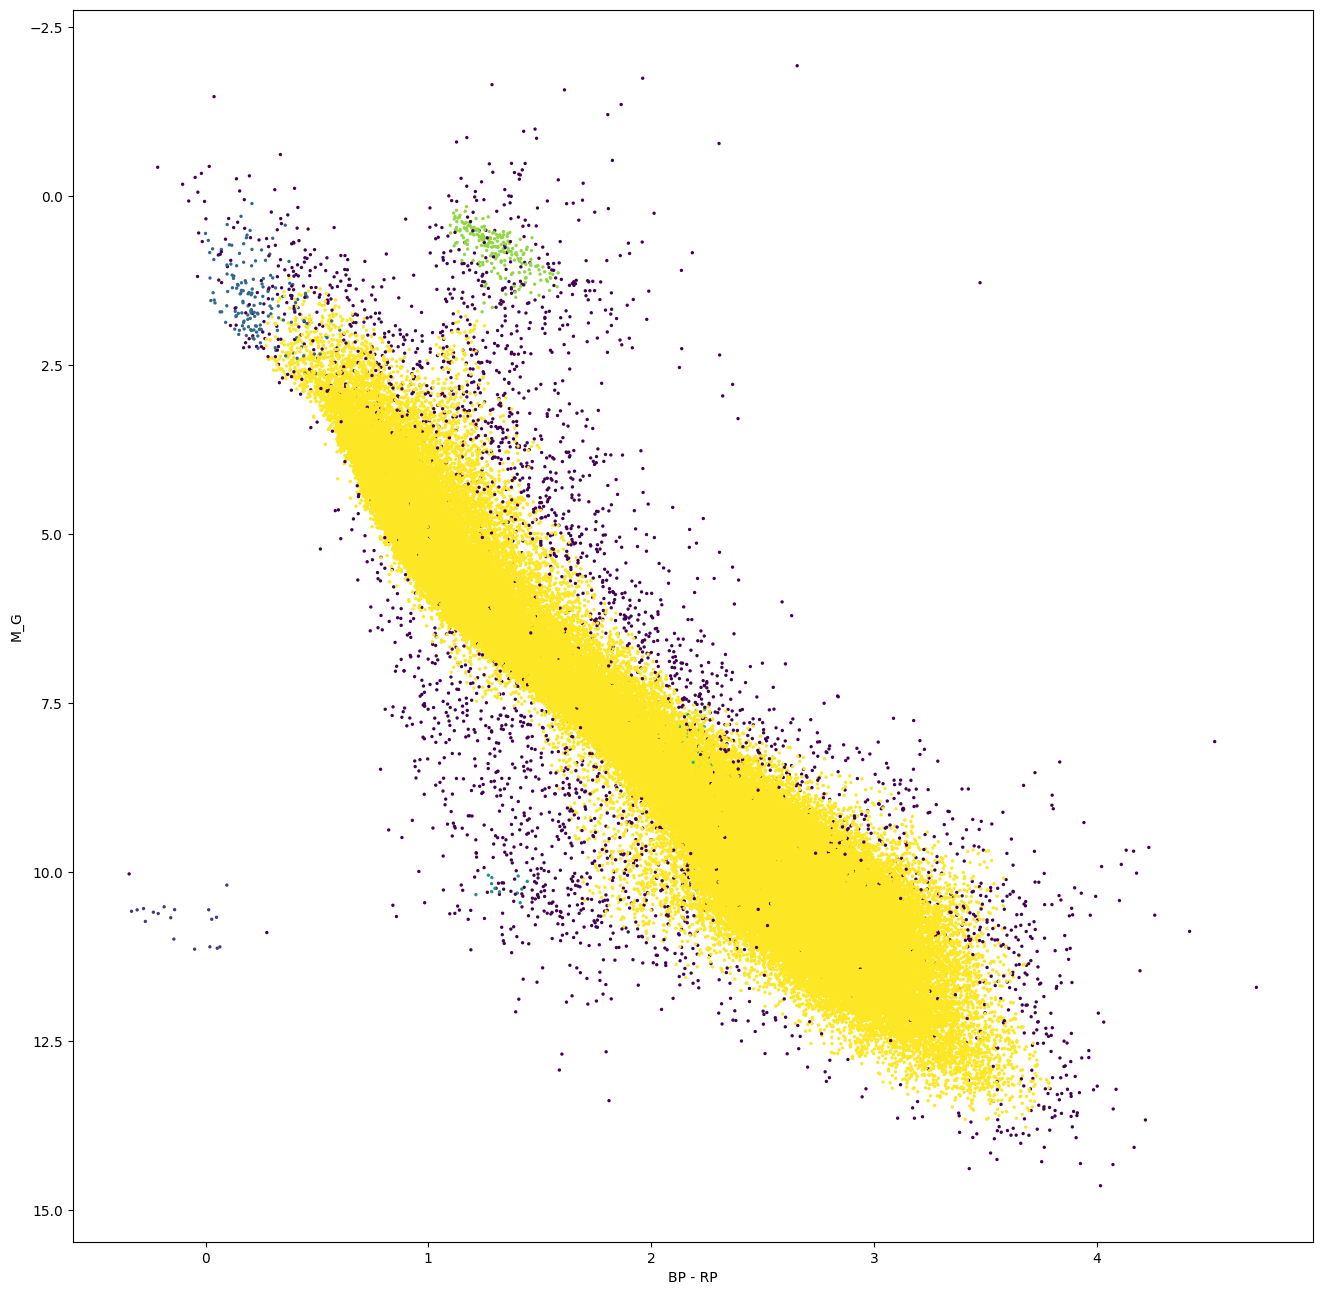

In [210]:
plt.figure(figsize=(16, 16))
plt.scatter(dados["bp_rp"], dados["abs_mag"], c = dados["hdbscan"], s=2)
plt.gca().invert_yaxis()
plt.xlabel("BP - RP")
plt.ylabel("M_G")
plt.show()

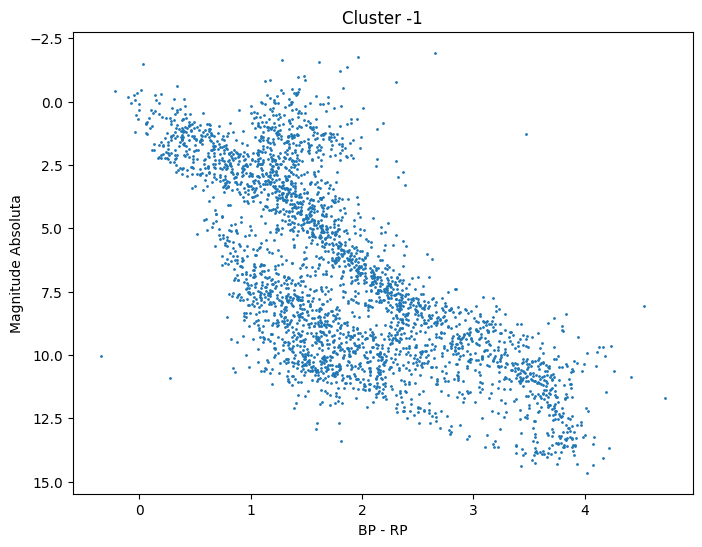

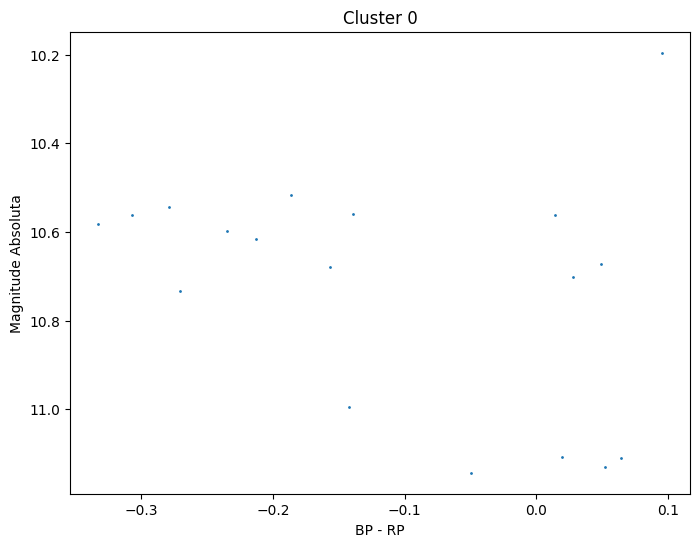

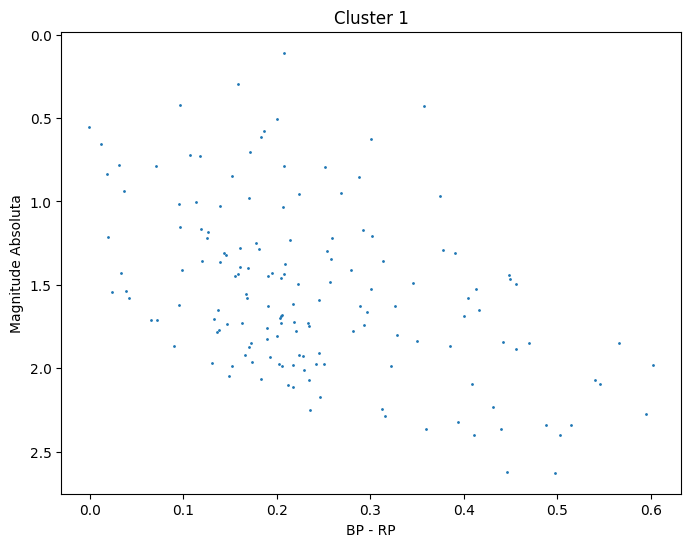

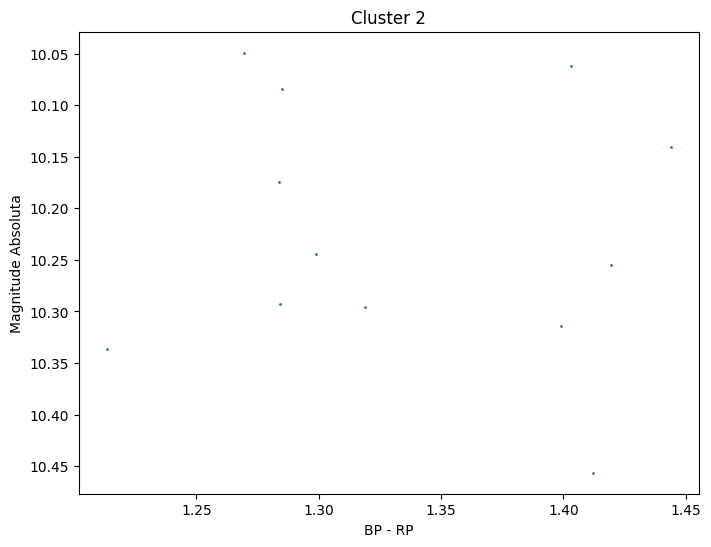

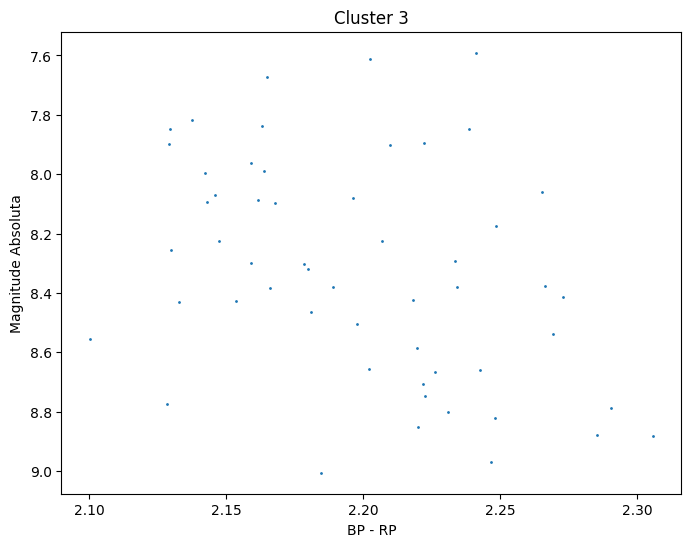

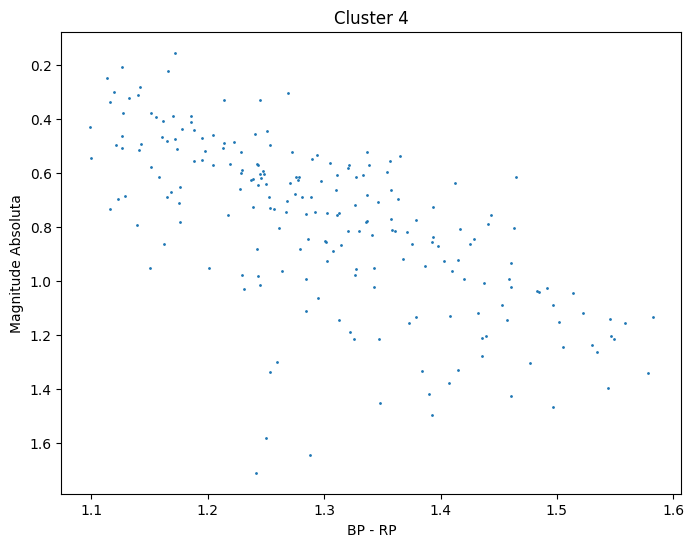

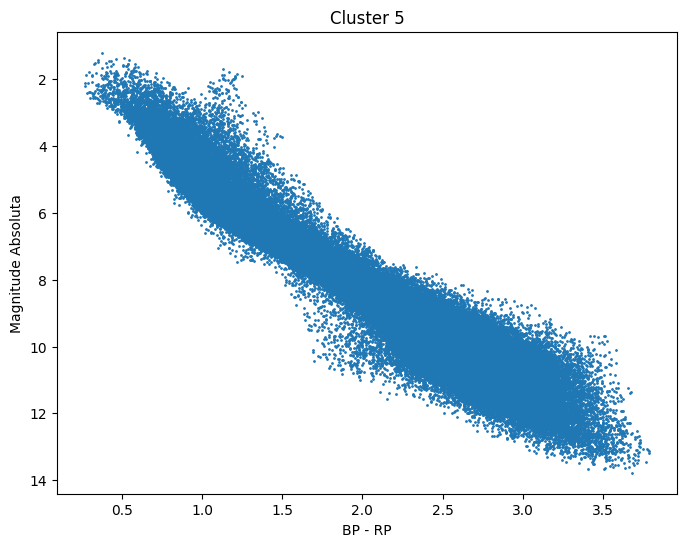

In [213]:
clusters = sorted(dados["hdbscan"].unique())

for c in clusters:
    subset = dados[dados["hdbscan"] == c]
    
    plt.figure(figsize=(8,6))
    plt.scatter(subset["bp_rp"],
                subset["abs_mag"],
                s=1)
    
    plt.gca().invert_yaxis()
    plt.xlabel("BP - RP")
    plt.ylabel("Magnitude Absoluta")
    plt.title(f"Cluster {c}")
    plt.show()
